<a href="https://colab.research.google.com/github/gechhaile/computer-vison/blob/main/imageclassificationwithkeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
`# This is formatted as code`
```
importing necessary packages 



In [1]:
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>


loading data set from sourse 

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  76.3M      0  0:00:10  0:00:10 --:--:-- 82.5M


Check the downloaded file 

In [3]:
!ls

kagglecatsanddogs_3367a.zip  sample_data


extract the downloaded file kagglecatsanddogs

In [4]:
!unzip -q kagglecatsanddogs_3367a.zip  


check extracted file 

In [5]:
%ls


 kagglecatsanddogs_3367a.zip   PetImages/       sample_data/
'MSR-LA - 3467.docx'          'readme[1].txt'


Now we have PetImages which have two class dogs and Cats


lets remove corrupted image from our data

In [6]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


After Removing corrupted file we will generate dattaset

In [7]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Visualizing our Data 

lets visualize the first 20 images
1 is for dogs and 0 for cats

from the code plt.subplot(4, 5, i + 1) 4 and 5 shows 20 images represented with  5 column with 4 rows

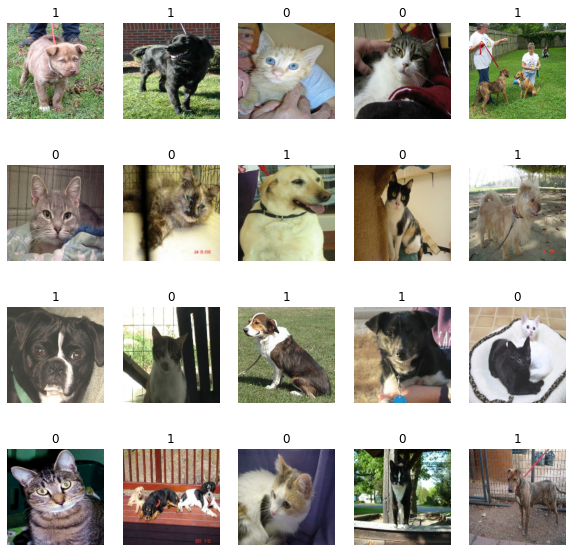

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

 image data augmentation


 Here when we have small data set we need to have artificialy introduce sample diversity 

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

lets visualize 

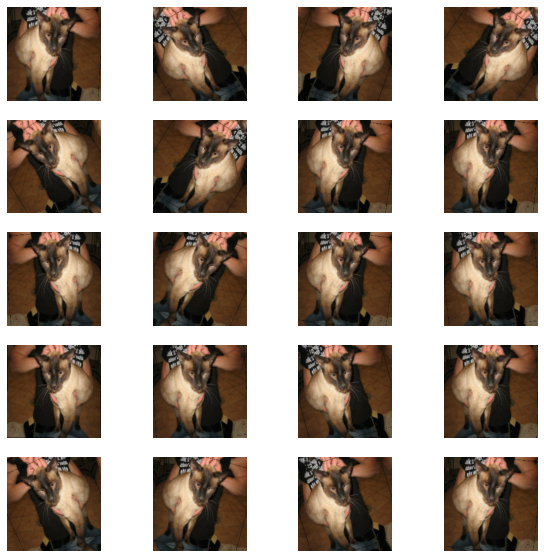

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(20):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Configure the dataset for performance

In [11]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Build a model

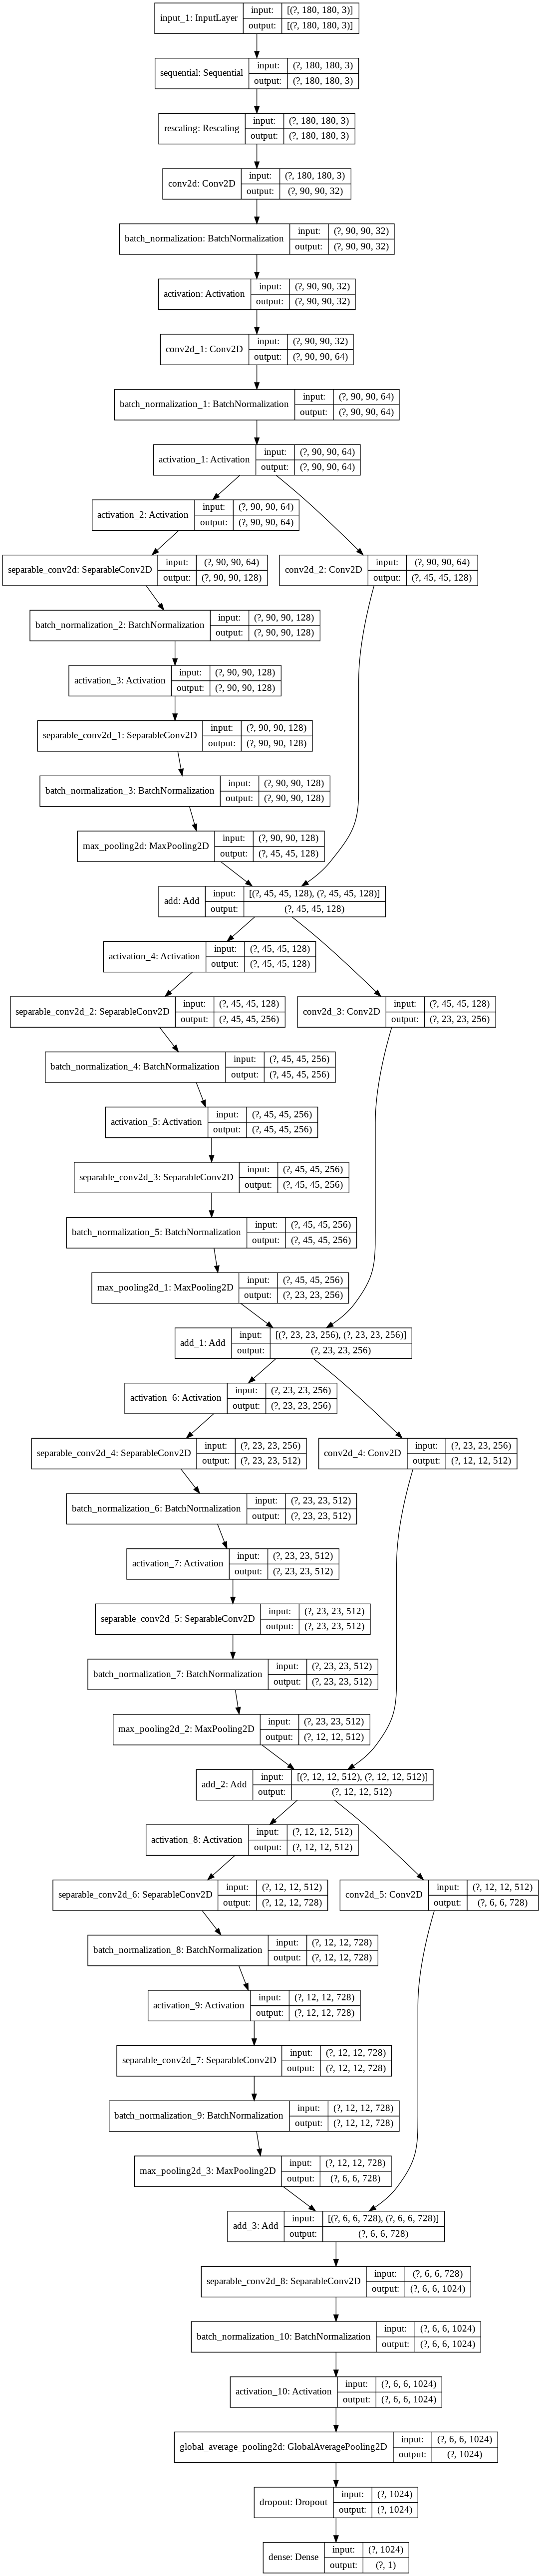

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Train the model

In [ ]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/60
586/586 [==============================] - 293s 500ms/step - loss: 0.6061 - accuracy: 0.6782 - val_loss: 0.5126 - val_accuracy: 0.7554
Epoch 2/60
586/586 [==============================] - 291s 497ms/step - loss: 0.4383 - accuracy: 0.7954 - val_loss: 0.3717 - val_accuracy: 0.8383
Epoch 3/60
586/586 [==============================] - 292s 498ms/step - loss: 0.3564 - accuracy: 0.8451 - val_loss: 0.2944 - val_accuracy: 0.8753
Epoch 4/60
586/586 [==============================] - 292s 499ms/step - loss: 0.2860 - accuracy: 0.8801 - val_loss: 0.2405 - val_accuracy: 0.9090
Epoch 5/60
586/586 [==============================] - 292s 498ms/step - loss: 0.2410 - accuracy: 0.8989 - val_loss: 0.3171 - val_accuracy: 0.8712
Epoch 6/60
586/586 [==============================] - 292s 499ms/step - loss: 0.2120 - accuracy: 0.9111 - val_loss: 0.9215 - val_accuracy: 0.6969
Epoch 7/60
586/586 [==============================] - 292s 498ms/step - loss: 0.1978 - accuracy: 0.9193 - val_loss: 0.4025 -

# New Section